In [3]:
import torch
import numpy as np
import torchvision.models as models
import Custom as CustomDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

"""
Do not run this code block without cuda()

Load in vgg16, 
"""
vgg16 = models.vgg16(pretrained=True).cuda()
#vgg16 = models.vgg16(pretrained=True)
customDataloader = CustomDataset.main('segments.csv') #for test dataloader
testDataloader = CustomDataset.main('testSegments.csv') #for test dataloader


for param in vgg16.parameters():
    param.requires_grad = False
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
vgg16_fcn = vgg16.features 
vgg16_fcn.cuda()




~~~| Custom.py Execution |~~~
Loaded dataset
~~~| Custom.py Complete |~~~


~~~| Custom.py Execution |~~~
Loaded dataset
~~~| Custom.py Complete |~~~



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [25]:
def getDataPoint(element, index):
    scores = []
    for frame in range(len(element['video'][index])):
        video = element['video'][index]
        #plt.imshow(video[frame].numpy())
        #plt.show(block=False)
        
        #print(data['video'][seg][frame].shape)
        #print(element['scores'][frame][index])
        scores.append(int(element['scores'][frame][index]))
    points = np.zeros((7,3), dtype=int)
    frames = np.add(*np.indices((7, 3)))
    if (1 in scores):
        boundary = scores.index(1)
        for i in range(7):
            for j in range(3):
                frames[i][j] = i + j
                if (i + j == boundary):
                    points[i][j] = 1
    return points.tolist(), frames.tolist(), video, index

def parseVideoMatrix(vid, positions):
    vid = vid.numpy()
    newData = np.zeros((7, 3, 3, 224,224))
    count = 0
    for i in positions:
        frames = np.zeros((3, 3, 224, 224))
        for j in range(len(i)):
            #Models expect 3xHxW
            #Current format before swaps, WxHx3
            frames[j,...] = np.swapaxes(vid[i[j]], 0, 2)
        newData[count,...] = frames
        count += 1
    return newData
    
def parseViewVids(vid, positions):
    vid = vid.numpy()
    newData = np.zeros((7, 3, 224, 224,3))
    count = 0
    for i in positions:
        frames = np.zeros((3, 224, 224, 3))
        for j in range(len(i)):
            #Models expect 3xHxW
            #Current format before swaps, WxHx3
            frames[j,...] = vid[i[j]]
        newData[count,...] = frames
        count += 1
    return newData

def viewVideo(vid):
    for i in vid:
        for j in i:
            plt.imshow(j)
            plt.show(block=False)

def accuracy(x,y):
    try:
        np.testing.assert_array_equal(x, y)
        res = True
    except AssertionError as err:
        res = False
        print (err)

"""
Reading in data to get single batch for training

batchData = []
for batch_i, data in enumerate(customDataloader): 
    print(batch_i)
    for i in range(len(data['video'])):
        scoreList, frameNums, vidData, index = getDataPoint(data, i)
        dataItem = parseVideoMatrix(vidData, frameNums)
        batchData.append([scoreList, dataItem])
        print(dataItem.shape)
        print(scoreList)
    if batch_i == 2:
        break
"""

"\nReading in data to get single batch for training\n\nbatchData = []\nfor batch_i, data in enumerate(customDataloader): \n    print(batch_i)\n    for i in range(len(data['video'])):\n        scoreList, frameNums, vidData, index = getDataPoint(data, i)\n        dataItem = parseVideoMatrix(vidData, frameNums)\n        batchData.append([scoreList, dataItem])\n        print(dataItem.shape)\n        print(scoreList)\n    if batch_i == 2:\n        break\n"

In [23]:
"""#x = np.asarray([[0, 0, 1], [1, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]])
x1 = np.asarray([[0.75921578,0.88907371,0.2766813 ],
 [0.61864459,0.04650604,0.21511941],
 [0.35091968,0.63173548,0.39149992],
 [0.73984203,0.58098107,0.96530972],
 [0.85951693,0.89359426,0.90629778],
 [0.22079354,0.56450811,0.4336098 ],
 [0.25300737,0.24504914,0.52868155]])
x2 = np.asarray([[0.75921578,0.88907371,0.2766813 ],
 [0.61824459,0.04620604,0.21511941],
 [0,0.63173548,0.39149992],
 [0.73984203,0,0.96530972],
 [0.85951693,0.79359426,0.90629778],
 [0,0.56450811,0.4336098 ],
 [0.25300737,0.24504914,0.52868155]])
#print(x1)
#y = np.asarray([[0, 0, 0], [1, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]])

print(np.sum(x1 == x2) / x1.size)"""

0.7142857142857143


0
[[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]


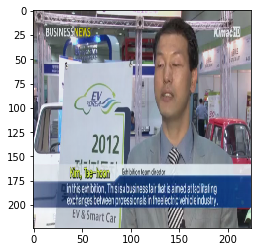

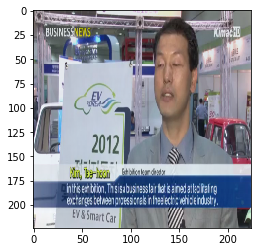

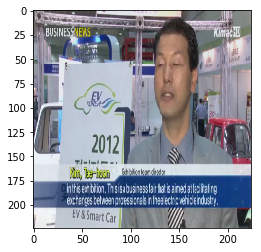

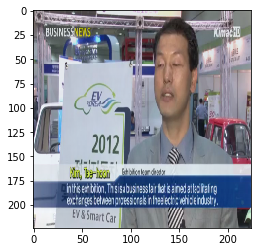

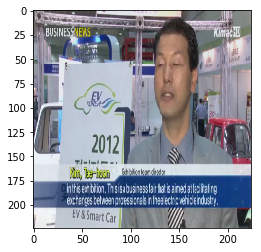

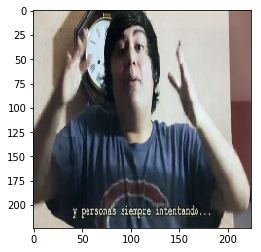

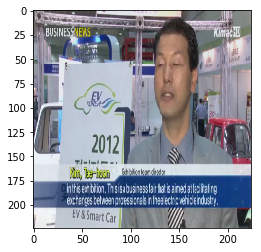

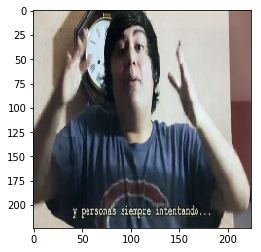

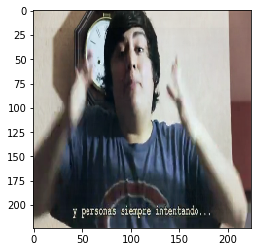

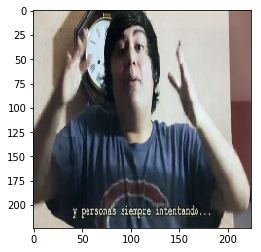

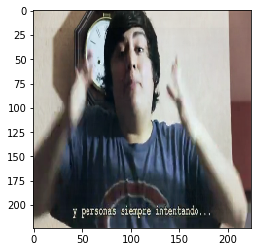

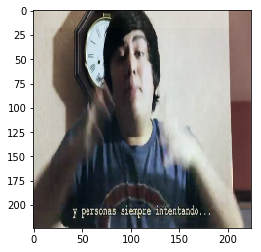

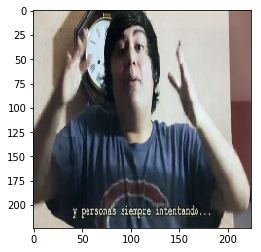

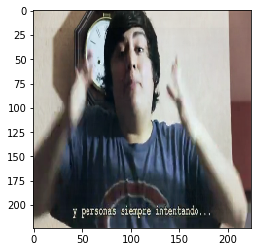

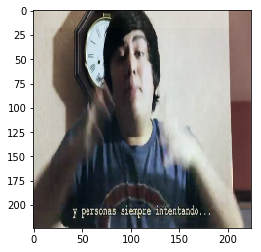

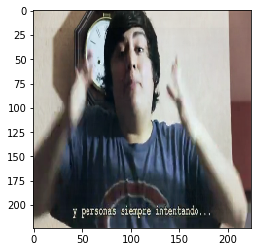

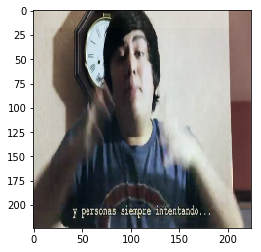

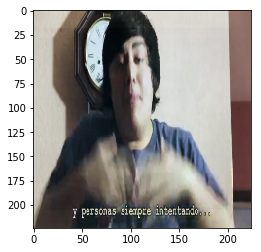

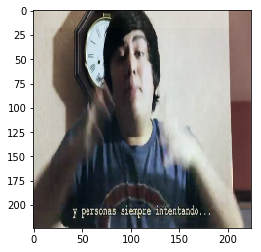

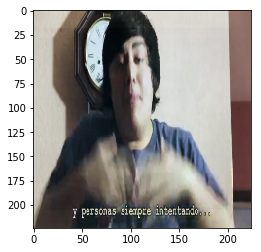

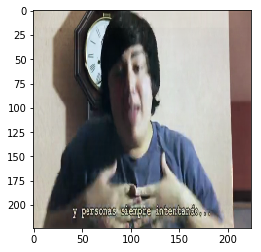

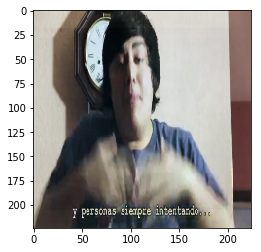

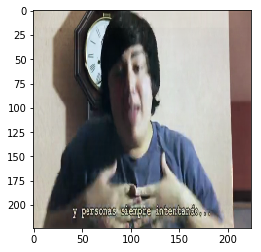

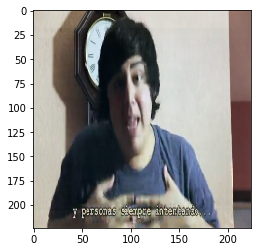

In [48]:
"""               
model = MyModel(512*7*7, 256)
print(batchOne.shape)
print(batchTwo.shape)
print(batchOne[:,0,:,:,:].shape)

out = np.squeeze(model(512*7*7, batchOne))
print(out.shape)
print(out)
out2 = np.squeeze(model(512*7*7, batchTwo))
print(out2.shape)
print(out2)
#Data Validation - Show first sequence of each data item
for i in range(len(batchData)):
    #Print ScoreList of Data to be shown
    print(batchData[i][0])
    for j in range(len(batchData[i][1])):
        frames = np.swapaxes(batchData[i][1][j], 1, 3)
        for f in frames:
            print(f.shape)
            plt.imshow(f)
            plt.show(block=False)
        break
for batch_i, batch_data in enumerate(customDataloader): 
        print(batch_i)
        for i in range(len(batch_data['video'])):
            scoreList, frameNums, vidData, index = getDataPoint(batch_data, i)
            dataItem = parseVideoMatrix(vidData, frameNums)
            data = [dataItem[0:4], dataItem[3:]]
            print(scoreList)
            for j in range(len(data)):
                for l in range(len(data[j])):
                    frames = np.swapaxes(data[j][l], 1, 3)
                    for f in frames:
                        plt.imshow(f)
                        plt.show(block=False)
            break
        break
        """


In [50]:
"""
USING SIGMOID
"""

import torch.nn as nn
from torch.nn.parameter import Parameter
class MyModel(nn.Module):
    def __init__(self, inputDim, outputDim):
        super(MyModel, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        #vgg16 = models.vgg16(pretrained=True).cuda()
        for param in vgg16.parameters():
            param.requires_grad = False
            # Replace the last fully-connected layer
            # Parameters of newly constructed modules have requires_grad=True by default
        self.vgg16_fcn = vgg16.features
        #self.vgg16_fcn.cuda()
        self.lstm = torch.nn.LSTM(inputDim, outputDim, 1, True, True, 0.5);
        self.fc = nn.Linear(outputDim, 1)
        self.flatten_parameters()
        self.sigmoid = nn.Sigmoid()
        self.inputDim = inputDim
    
    def flatten_parameters(self):
        self.lstm.flatten_parameters()
        
    def forward(self, x):
        newBatch = []
        for t in range(len(x[1])):
            newBatch.append(self.vgg16_fcn(x[:,t,:,:,:].float()))
        grad = False
        
        #4 x 3 x (512 x 7 x 7)
        vggOut = torch.stack(newBatch, 1).detach_()
        #print(vggOut.shape)
        
        #4 x 3 x 25088
        test = vggOut.view((4,3,-1))
        #print(test.shape)
        
        #Output from LSTM 4 x 3 x 256
        lstmOut, _ = self.lstm(test)
        #print(lstmOut.shape)
        
        #Output from Fully Connected Layer 4 x 3 x 1
        #fcOut = self.fc(lstmOut)
        #print(fcOut)
        #return fcOut
        
        sigOut = self.sigmoid(self.fc(lstmOut))
        #print(sigOut)
        return sigOut

In [ ]:
"""
Not Using Cuda
Extremely Slow
"""
model = MyModel(512*7*7, 256)
batchOne = dataItem[0:4]
batchTwo = dataItem[3:]
#print(batchOne.shape)
#print(batchTwo.shape)
data = [batchOne, batchTwo]
#Ground Truth
scoreOnes = np.squeeze(scoreList[0:4])
scoreTwo = np.squeeze(scoreList[3:])
GT = [scoreOnes, scoreTwo]

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    for i in range(len(data)):
        x = Variable(torch.tensor(data[i], dtype=torch.float32))
        y = Variable(torch.tensor(GT[i], dtype=torch.float32))
        optimizer.zero_grad()
        out = model(x)
        out = out.squeeze()
        error = nn.functional.binary_cross_entropy(input=out, target=y, reduce=True)
        error.backward()        
        optimizer.step()
    #if epoch % 5 == 0:
        print('epoch %d:' % epoch, error.item())
"""
Not Using Cuda
Extremely Slow
"""

In [53]:
"""
Using Cuda

"""

model = MyModel(512*7*7, 256).cuda()
#batchOne = dataItem[0:4]
#batchTwo = dataItem[3:]
#print(batchOne.shape)
#print(batchTwo.shape)
#data = [batchOne, batchTwo]
#Ground Truth
#scoreOnes = np.squeeze(scoreList[0:4])
#scoreTwo = np.squeeze(scoreList[3:])
#GT = [scoreOnes, scoreTwo]

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 1000
for epoch in range(num_epochs):
    for batch_i, batch_data in enumerate(customDataloader): 
        print(batch_i)
        for i in range(len(batch_data['video'])):
            scoreList, frameNums, vidData, index = getDataPoint(batch_data, i)
            dataItem = parseVideoMatrix(vidData, frameNums)
            data = [dataItem[0:4], dataItem[3:]]
            #Ground Truth
            GT = [np.squeeze(scoreList[0:4]), np.squeeze(scoreList[3:])]
            for j in range(2):
                x = Variable(torch.tensor(data[j], dtype=torch.float32)).cuda()
                y = Variable(torch.tensor(GT[j], dtype=torch.float32)).cuda()
                optimizer.zero_grad()
                out = model(x)
                out = out.squeeze()
                error = nn.functional.binary_cross_entropy(input=out, target=y, reduce=True).cuda()
                error.backward()        
                optimizer.step() 
                if ((epoch) % 100 == 0) and (batch_i % 25 == 0):
                    print('item: ' + str(i+1) + ' epoch:' + str(epoch) + '\n\tbatch: ' + str(batch_i) + ', error: ' + str(error.item()))
                
testData = []
for batch_i, data in enumerate(testDataloader): 
    for i in range(len(data['video'])):
        scoreList, frameNums, vidData, index = getDataPoint(data, i)
        dataItem = parseVideoMatrix(vidData, frameNums)
        testData.append([scoreList, dataItem])
        print(dataItem.shape)
        print(scoreList)
    if batch_i == 1:
        break
        
for i in range(len(testData)):
    #Within batchData - batchData[0]: score, batchData[1]:video data
    data = [testData[i][1][0:4], testData[i][1][3:]]
    #Ground Truth
    GT = [np.squeeze(testData[i][0][0:4]), np.squeeze(testData[i][0][3:])]
    for j in range(2):
        x = Variable(torch.tensor(data[j], dtype=torch.float32)).cuda()
        y = Variable(torch.tensor(GT[j], dtype=torch.float32)).cuda()
        optimizer.zero_grad()
        out = model(x)
        out = out.squeeze()
        error = nn.functional.binary_cross_entropy(input=out, target=y, reduce=True).cuda()
        error.backward()        
        optimizer.step() 
        print('item: ' + str(i+1) + '\n\tbatch: ' + str(j) + ', error: ' + str(error.item()))



0
item: 1 epoch:0
	batch: 0, error: 0.6813888549804688
item: 1 epoch:0
	batch: 0, error: 0.5522590279579163
item: 2 epoch:0
	batch: 0, error: 0.6874181628227234
item: 2 epoch:0
	batch: 0, error: 0.6504289507865906
item: 3 epoch:0
	batch: 0, error: 0.6546360850334167
item: 3 epoch:0
	batch: 0, error: 0.5945578813552856
item: 4 epoch:0
	batch: 0, error: 0.5579777359962463
item: 4 epoch:0
	batch: 0, error: 0.5727015733718872
1
2
3
4
5
6
7
8
9
10
11
12
13


KeyboardInterrupt: 